<a href="https://colab.research.google.com/github/mdehghani86/AppliedGenAI/blob/main/LangGraph_Tutorial_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **LangGraph Lab : Part 1 🚀**
- Prof. Dehghani
## **Building More Controllable LLM Agents with LangGraph**

## **Introduction**
LangGraph is a framework designed for building **agent and multi-agent applications** with structured control. While large language models (LLMs) are powerful, they often require **more precise workflows** to ensure reliability.

Many real-world applications need agents to follow **specific steps**, such as always calling a certain tool first or adjusting their prompts based on the current state. Traditional agent frameworks may not provide enough control for these scenarios. LangGraph introduces a **graph-based approach** that allows developers to define structured workflows while still benefiting from LLM flexibility.

This lab is adapted from [LangChain Academy's Intro to LangGraph](https://academy.langchain.com/courses/intro-to-langgraph), which provides additional details and use cases.

## **Lab Objectives**
By the end of this lab, the following concepts will be covered:
- The role of **graphs** in LLM-based agent workflows
- How to define **nodes** (decision points) and **edges** (paths) in LangGraph
- Implementing an **agent with controlled decision-making**
- Exploring **multi-agent interactions** within a structured framework

## **Getting Started**
Run the following cell to install the required libraries:



In [13]:
# 🚀 Install necessary libraries for LangGraph-based agent workflows
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langchain_community tavily-python langgraph

# langchain_openai: Provides integration with OpenAI models
# langchain_core: Core components for building LangChain applications
# langchain_community: Community-contributed integrations and tools
# tavily-python: Enables web search capabilities for retrieval-augmented generation (RAG)


In [3]:
# 🔑 Retrieve OpenAI API key securely from Colab's userdata storage
import os
from google.colab import userdata

openai_api_key = userdata.get('OpenAI_Key')  # Fetch the stored API key

# Ensure the key is set as an environment variable
if openai_api_key:
    os.environ["OPENAI_API_KEY"] = openai_api_key
    print("✅ OpenAI API key successfully set.")
else:
    print("⚠️ OpenAI API key not found. Please store it using Colab's userdata feature.")


✅ OpenAI API key successfully set.


# 🤖 Using GPT-4o and GPT-3.5 in LangChain  

This section initializes **GPT-4o** and **GPT-3.5 Turbo** models using LangChain.  
It demonstrates how to:  
- Create a **human message** and send it as part of a conversation.  
- Invoke both models with **single text inputs** and **message lists**.  
- Print the responses for comparison.  

Run the code to see how different models respond to the same input.


In [8]:
# 🤖 Initialize OpenAI Chat Models (GPT-4o & GPT-3.5)

from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage

# Set up GPT-4o and GPT-3.5 Turbo with zero temperature for deterministic responses
gpt4o_chat = ChatOpenAI(model="gpt-4o", temperature=0)
gpt35_chat = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)

# 🗣️ Create a human message instance
msg = HumanMessage(content="Hello world", name="Lance")

# Store the message inside a list (models expect message sequences)
messages = [msg]

#  Invoke the GPT-4o model with a message list
response_4o = gpt4o_chat.invoke(messages)

#  Invoke the GPT-4o and GPT-3.5 models with a simple text prompt
response_4o_text = gpt4o_chat.invoke("hello world")
response_35_text = gpt35_chat.invoke("hello world")

# ✅ Display responses
print("GPT-4o Response:", response_4o)
print("GPT-4o (Text) Response:", response_4o_text)
print("GPT-3.5 Response:", response_35_text)


GPT-4o Response: content='Hello! How can I assist you today?' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 11, 'total_tokens': 21, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_f9f4fb6dbf', 'id': 'chatcmpl-BCTupbnZCCHvyTHNlkeUljURhDedc', 'finish_reason': 'stop', 'logprobs': None} id='run-703415df-717d-49ff-89fe-a86007a49afc-0' usage_metadata={'input_tokens': 11, 'output_tokens': 10, 'total_tokens': 21, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}
GPT-4o (Text) Response: content='Hello! How can I assist you today?' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 9, 'total_token

# 🔎 What is Tavily?  

[Tavily](https://tavily.com/) is a web search API that allows AI applications to retrieve real-time information from the internet.  
It is commonly used in *retrieval-augmented generation (RAG)* systems, where an LLM enhances responses by fetching *up-to-date* and relevant data from external sources.  

In this lab, Tavily will be used to perform web searches and integrate real-world information into LangGraph workflows.  


In [9]:
# 🔑 Retrieve Tavily API key securely from Colab's userdata storage
tavily_api_key = userdata.get('Tavily_Key')  # Fetch the stored API key

# Ensure the key is set as an environment variable
if tavily_api_key:
    os.environ["TAVILY_API_KEY"] = tavily_api_key
    print("✅ Tavily API key successfully set.")
else:
    print("⚠️ Tavily API key not found. Please store it using Colab's userdata feature.")


✅ Tavily API key successfully set.


In [10]:
# 🔍 Using Tavily for Web Search in LangChain

from langchain_community.tools.tavily_search import TavilySearchResults

# Initialize Tavily search tool with a maximum of 3 results
tavily_search = TavilySearchResults(max_results=3)

# Perform a web search query
query = "What is LangGraph?"
search_docs = tavily_search.invoke(query)

# ✅ Display the retrieved search results
print("🔹 Tavily Search Results for:", query)
print(search_docs)


🔹 Tavily Search Results for: What is LangGraph?
[{'title': "Introduction to LangGraph: A Beginner's Guide - Medium", 'url': 'https://medium.com/@cplog/introduction-to-langgraph-a-beginners-guide-14f9be027141', 'content': 'LangGraph is a powerful tool for building stateful, multi-actor applications with Large Language Models (LLMs). It extends the LangChain library, allowing you to coordinate multiple chains (or actors) across multiple steps of computation in a cyclic manner. In this article, we’ll introduce LangGraph, walk you through its basic concepts, and share some insights and common points of confusion for beginners.\nWhat is LangGraph? [...] LangGraph is a library built on top of LangChain, designed to add cyclic computational capabilities to your LLM applications. While LangChain allows you to define chains of computation (Directed Acyclic Graphs or DAGs), LangGraph introduces the ability to add cycles, enabling more complex, agent-like behaviors where you can call an LLM in a 

# The Simplest Graph  

Let's build a simple graph with **three nodes** and **one conditional edge**. This structure allows an agent to make a decision at a branching point, directing the flow based on predefined conditions.  

<img src="https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dba5f465f6e9a2482ad935_simple-graph1.png" width="600"/>  

This example demonstrates how **LangGraph** enables structured decision-making while maintaining flexibility.  


## 🛠️ Understanding Graph Components  

LangGraph workflows consist of **three main components**: *State, Nodes, and Edges*. Each plays a key role in defining how information flows through the graph.  

---

## 🧠 State  

The **State** ([docs](https://langchain-ai.github.io/langgraph/concepts/low_level/#state)) acts as the **shared memory** of the graph, storing data that nodes can read and modify.  

- Every *node and edge* interacts with the state.  
- It is defined using `TypedDict` from Python’s `typing` module, which helps structure data with type hints.  
- Nodes modify the state by updating specific keys.  

---

## 🔵 Nodes  

A **Node** ([docs](https://langchain-ai.github.io/langgraph/concepts/low_level/#nodes)) is a simple **Python function** that processes the state.  

- The **first argument** of a node function is always the *state*.  
- Nodes can *read and modify* the state using keys like `state['graph_state']`.  
- By default, when a node returns a value, it updates the state and replaces the previous value ([reducers](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) handle this).  

---

## 🔀 Edges  

An **Edge** ([docs](https://langchain-ai.github.io/langgraph/concepts/low_level/#edges)) connects nodes and controls how data moves between them.  

Two types of edges exist:  
- **Normal Edges** → Always transition from one node to the next (e.g., `node_1 → node_2`).  
- **Conditional Edges** ([docs](https://langchain-ai.github.io/langgraph/concepts/low_level/#conditional-edges)) → Decide the next node dynamically based on logic.  

Conditional edges *act like decision points*, determining the next step in the workflow.  


In [12]:
from typing_extensions import TypedDict
from typing import Literal
import random

# 🎯 Define the State Schema
# The state acts as shared memory for the graph.
# It stores a key-value pair where 'graph_state' holds a string that evolves as nodes modify it.
class State(TypedDict):
    graph_state: str  # Tracks the sentence as it builds through the nodes

# 🔵 Define Nodes
# Each node modifies the 'graph_state' by appending its own text.
# Nodes simulate a simple sentence-building process.

def node_1(state: State) -> State:
    """Node 1 initializes the sentence with 'I am'."""
    print("--- Node 1 ---")
    return {"graph_state": state["graph_state"] + " I am"}

def node_2(state: State) -> State:
    """Node 2 completes the sentence with 'happy!'."""
    print("--- Node 2 ---")
    return {"graph_state": state["graph_state"] + " happy!"}

def node_3(state: State) -> State:
    """Node 3 completes the sentence with 'sad!'."""
    print("--- Node 3 ---")
    return {"graph_state": state["graph_state"] + " sad!"}

# 🔀 Define the Decision Function
# This function decides whether to send the state to Node 2 or Node 3.
# It randomly picks between the two, simulating an unpredictable emotional outcome.

def decide_mood(state: State) -> Literal["node_2", "node_3"]:
    """Randomly selects between Node 2 (happy) and Node 3 (sad)."""

    # Simulate a 50/50 decision
    if random.random() < 0.5:
        return "node_2"  # 50% chance to go to Node 2 (happy)
    return "node_3"  # 50% chance to go to Node 3 (sad)


## 🚀 Graph Construction  

Now, it's time to build the graph using the **components** defined earlier. The **StateGraph class** is used to create and manage the graph structure.  

### 🏗️ Steps to Build the Graph  
1. **Initialize the Graph** → Create a `StateGraph` using the `State` class.  
2. **Add Nodes and Edges** → Define how the graph flows.  
3. **Use Special Nodes**:  
   - **`START` Node** → Sends user input into the graph.  
   - **`END` Node** → Represents a terminal state.  
4. **Compile the Graph** → Ensures structural validity.  
5. **Visualize** → Convert it into a **Mermaid diagram** for better understanding.  

### 🔗 Reference Table  

| Concept       | Documentation Link |
|--------------|------------------|
| StateGraph Class | [StateGraph Docs](https://langchain-ai.github.io/langgraph/concepts/low_level/#stategraph) |
| START Node   | [START Node Docs](https://langchain-ai.github.io/langgraph/concepts/low_level/#start-node) |
| END Node     | [END Node Docs](https://langchain-ai.github.io/langgraph/concepts/low_level/#end-node) |
| Graph Compilation | [Compiling a Graph](https://langchain-ai.github.io/langgraph/concepts/low_level/#compiling-your-graph) |
| Mermaid Diagrams | [Mermaid Docs](https://github.com/mermaid-js/mermaid) |

This approach makes the graph more **structured, adaptable, and easy to debug**.  


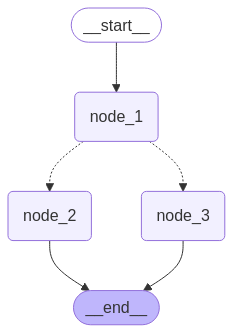

In [13]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# 🏗️ Initialize the Graph Builder
# The StateGraph is created using the State schema defined earlier.
builder = StateGraph(State)

# 🔵 Add Nodes
# Each node represents a step in the process and modifies the graph_state.
builder.add_node("node_1", node_1)  # Starts the sentence
builder.add_node("node_2", node_2)  # Appends "happy!"
builder.add_node("node_3", node_3)  # Appends "sad!"

# 🔗 Define Graph Flow (Edges)
# Edges define how nodes connect to each other.

# The START node sends input to "node_1"
builder.add_edge(START, "node_1")

# From "node_1", the next step is decided dynamically using the decide_mood function.
builder.add_conditional_edges("node_1", decide_mood)

# "node_2" (happy) and "node_3" (sad) both lead to the END node.
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# ✅ Compile the Graph
# This ensures that the structure is valid and ready for execution.
graph = builder.compile()

# 🖼️ Visualize the Graph
# Generates a Mermaid diagram to display the flow of nodes and edges.
display(Image(graph.get_graph().draw_mermaid_png()))


## Graph Invocation  

The compiled graph follows the [runnable](https://python.langchain.com/docs/concepts/runnables/) protocol, providing a standardized way to execute LangChain components. The `invoke` method is used to start execution, with an input dictionary like `{"graph_state": "Hi, this is Lance."}` setting the initial state. The graph begins at the `START` node and moves through the defined nodes (`node_1`, `node_2`, `node_3`) based on the control flow. A conditional edge determines whether the execution moves from `node_1` to `node_2` or `node_3`, following a 50/50 probability rule. Each node processes the current state, modifies the `graph_state` value, and returns the updated state. The execution continues along the directed edges until it reaches the `END` node, where the final graph state is returned.


In [14]:
graph.invoke({"graph_state" : "Hi, this is Lance."})

--- Node 1 ---
--- Node 2 ---


{'graph_state': 'Hi, this is Lance. I am happy!'}

# ✈️ Airport Security Screening Simulation (LangGraph Hands-On)

## 🛫 Scenario
In this exercise, we simulate an **airport security screening process** using **LangGraph**. Passengers arrive at security and are categorized into:
1. **TSA PreCheck (20%)** → Fast screening
2. **Regular Screening (80%)** → Standard security check
3. **Additional Screening (10% of Regular Passengers)** → Extra checks before proceeding to gates

Below is a **visual representation** of the screening process:

![Airport Security Flow](https://www.dropbox.com/scl/fi/o3ipy33svrcg64myu0u0s/AirPort_Security.png?rlkey=d6hc4bqdphzducnixba9ic2ai&dl=1)

---
## Task: Complete the Missing Code
Your goal is to **fill in the placeholders (`-------`)** to define functions and logic in the LangGraph framework.


In [9]:
from typing_extensions import TypedDict
from typing import Literal
import random
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END


# 🎯 Define the State Schema
class AirportState(TypedDict):
    passenger_type: str  # Tracks whether passenger is Regular or TSA PreCheck

# 🔵 Define Nodes
def start_node(state: AirportState) -> AirportState:
    """Initial step where a passenger enters security."""
    print("🛫 Passenger arrives at security.")
    return state

def tsa_screening(state: -------) -> -------:
    """TSA PreCheck passengers go through expedited screening."""
    print("🟢 TSA PreCheck passenger goes through expedited screening.")
    return state

def regular_screening(state: -------) -> -------:
    """Regular passengers go through standard screening."""
    print("🔎 Regular passenger goes through standard screening.")
    return state

def additional_screening(state: -------) -> -------:
    """Additional screening for some regular passengers."""
    print("⚠️ Additional screening required for passenger.")
    return -------

def gates(state: -------) -> -------:
    """All passengers proceed to the boarding gates."""
    print("✅ Passenger cleared security. Proceeding to Gates!")
    return -------

# 🔀 Define the First Decision Function (TSA or Regular)
def assign_passenger_type(state: -------) -> Literal["-------", "-------"]:
    """Randomly assigns passengers to TSA PreCheck (20%) or Regular (80%)."""
    if random.random() < -------:
        print("🟢 Passenger assigned to TSA PreCheck.")
        return "tsa_screening"
    else:
        print("🔵 Passenger assigned to Regular Screening.")
        return "regular_screening"

# 🔀 Define the Second Decision Function (Regular -> Additional Screening or Gates)
def additional_screening_decision(state: -------) -> -------["-------", "-------"]:
    """10% of regular passengers go to additional screening, while 90% proceed to gates."""
    if random.random() < -------:
        print("⚠️ Passenger selected for additional screening.")
        return "-------"
    else:
        print("✅ Passenger cleared security after regular screening.")
        return "-------"

# 🏗️ Build the Graph
builder = StateGraph(-------)

# 🔵 Add Nodes
builder.-------("start_node", -------)
builder.add_node("tsa_screening", -------)
builder.add_node("regular_screening", -------)
builder.add_node("additional_screening", -------)
builder.add_node("gates", -------)

# 🔗 Define Graph Flow (Edges)
builder.-------(START, "-------")
builder.add_conditional_edges("start_node", -------)
builder.add_edge("tsa_screening", "-------")
builder.add_conditional_edges("regular_screening", -------)
builder.add_edge("additional_screening", "-------")
builder.add_edge("gates", END)

# ✅ Compile the Graph
graph = builder.-------

# 🖼️ Visualize the Graph
display(Image(graph.get_graph().-------))

# 🚀 Run the Graph
graph.-------({})


SyntaxError: invalid syntax (<ipython-input-9-1a0b686b853c>, line 27)

In [52]:
# 🔄 Refresh this cell to see how the model works on different scenarios
graph.invoke({})


🛫 Passenger arrives at security.
🟢 Passenger assigned to TSA PreCheck.
🟢 TSA PreCheck passenger goes through expedited screening.
✅ Passenger cleared security. Proceeding to Gates!


In [8]:
!pip install -U langchain-openai


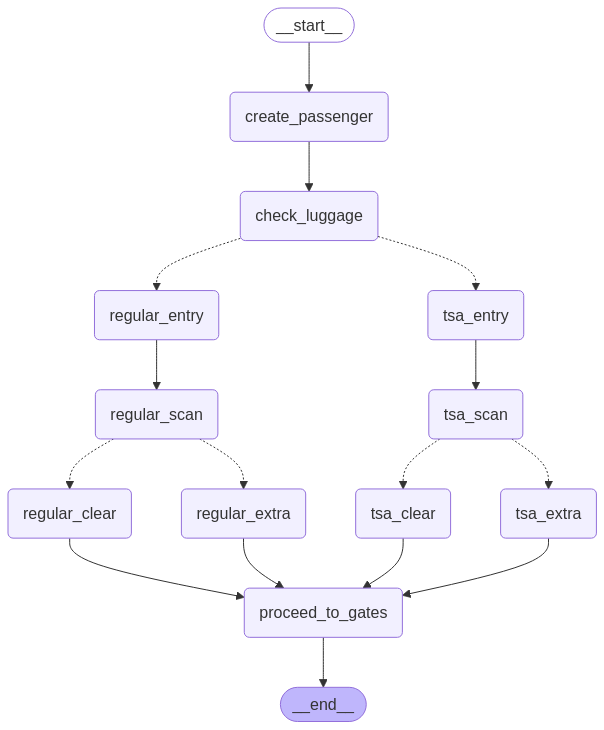

🛫 Passenger enters airport security.
🎒 Luggage: ['Laptop', 'Sweater', 'Novel', 'Toothbrush', 'Sunglasses', 'Pair of shoes']
🎒 Luggage: ['Laptop', 'Sweater', 'Novel', 'Toothbrush', 'Sunglasses', 'Pair of shoes']
🔵 Passenger is Regular Screening.
🔎 Regular passenger enters screening.
🛃 AI Screening Decision: ✅ Cleared for Gates. (No, the items in the luggage are all common personal belongings and do not include anything dangerous or suspicious.)
📊 Stats: Total: 1, Flagged: 0
✅ Passenger cleared security. Proceeding to gates!
✅ Passenger cleared security. Proceeding to gates!


{'luggage': ['Laptop',
  'Sweater',
  'Novel',
  'Toothbrush',
  'Sunglasses',
  'Pair of shoes'],
 'screening_notes': ['No, the items in the luggage are all common personal belongings and do not include anything dangerous or suspicious.'],
 'flagged': False,
 'total_passengers': 1,
 'flagged_passengers': 0}

In [48]:
from typing_extensions import TypedDict, Annotated
from typing import Literal
import random
import json
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from google.colab import userdata
from langchain.schema import AIMessage, HumanMessage

# 🔑 Secure OpenAI API Key
OPENAI_API_KEY = userdata.get('OpenAI_Key')
llm = ChatOpenAI(model="gpt-4", temperature=0.7, api_key=OPENAI_API_KEY)

# 🎯 Define State Schema
class AirportState(TypedDict):
    passenger_type: str  # "TSA" or "Regular"
    luggage: Annotated[list, "merge"]  # Luggage details (set once)
    screening_notes: Annotated[list, "merge"]  # Screening decisions
    flagged: bool  # True if extra screening is needed
    total_passengers: int  # Counter for total passengers
    flagged_passengers: int  # Counter for flagged screenings

# 🔵 Define Nodes
def create_passenger(state: AirportState) -> AirportState:
    """Creates a passenger and assigns luggage."""
    print("🛫 Passenger enters airport security.")
    return check_luggage(state)

def check_luggage(state: AirportState) -> AirportState:
    """AI generates a list of items for the passenger luggage."""
    if "luggage" not in state or not state["luggage"]:
        prompt = (
            "List 6-10 items in the passenger's luggage "
            "Format response as a JSON list (e.g., [\"Laptop\", \"Liquid bottle\", \"Knife\"])."
        )

        response = llm([HumanMessage(content=prompt)])

        try:
            items = json.loads(response.content)
            if isinstance(items, list):
                state["luggage"] = items
            else:
                raise ValueError("Invalid format received from LLM.")
        except json.JSONDecodeError:
            state["luggage"] = ["Unknown Item"]  # Fallback

    print(f"🎒 Luggage: {state['luggage']}")
    return state

def assign_lane(state: AirportState) -> Literal["tsa_entry", "regular_entry"]:
    """Assigns passenger to TSA or Regular screening."""
    if random.random() < 0.3:
        print("🟢 Passenger is TSA PreCheck.")
        state["passenger_type"] = "TSA"
        return "tsa_entry"
    else:
        print("🔵 Passenger is Regular Screening.")
        state["passenger_type"] = "Regular"
        return "regular_entry"

# ✅ TSA-ONLY SCREENING PATH
def tsa_entry(state: AirportState) -> AirportState:
    """TSA passengers enter the TSA checkpoint."""
    print("🟢 TSA passenger enters screening.")
    return state

def tsa_scan(state: AirportState) -> AirportState:
    """AI scans TSA passenger luggage for prohibited items."""
    return run_ai_screening(state, "TSA")

def tsa_decision(state: AirportState) -> Literal["tsa_extra", "tsa_clear"]:
    """Determines if TSA passenger needs extra screening."""
    return "tsa_extra" if state["flagged"] else "tsa_clear"

def tsa_extra(state: AirportState) -> AirportState:
    """TSA passengers flagged for extra screening."""
    print("⚠️ TSA passenger undergoing additional screening.")
    state.setdefault("screening_notes", []).append("TSA passenger sent to extra screening.")
    return state

def tsa_clear(state: AirportState) -> AirportState:
    """TSA passenger cleared to board."""
    return proceed_to_gates(state)

# ✅ REGULAR-ONLY SCREENING PATH
def regular_entry(state: AirportState) -> AirportState:
    """Regular passengers enter the standard security checkpoint."""
    print("🔎 Regular passenger enters screening.")
    return state

def regular_scan(state: AirportState) -> AirportState:
    """AI scans Regular passenger luggage for prohibited items."""
    return run_ai_screening(state, "Regular")

def regular_decision(state: AirportState) -> Literal["regular_extra", "regular_clear"]:
    """Determines if Regular passenger needs extra screening."""
    return "regular_extra" if state["flagged"] else "regular_clear"

def regular_extra(state: AirportState) -> AirportState:
    """Regular passengers flagged for extra screening."""
    print("⚠️ Regular passenger undergoing additional screening.")
    state.setdefault("screening_notes", []).append("Regular passenger sent to extra screening.")
    return state

def regular_clear(state: AirportState) -> AirportState:
    """Regular passenger cleared to board."""
    return proceed_to_gates(state)

# ✅ COMMON FINAL NODE
def proceed_to_gates(state: AirportState) -> AirportState:
    """Passengers cleared from both TSA & Regular screenings go to gates."""
    print("✅ Passenger cleared security. Proceeding to gates!")
    return state

# ✅ AI SCREENING FUNCTION (Shared)
def run_ai_screening(state: AirportState, passenger_type: str) -> AirportState:
    """AI determines if luggage requires additional screening."""
    if "total_passengers" not in state:
        state["total_passengers"] = 0
        state["flagged_passengers"] = 0

    state["total_passengers"] += 1  # Increment passenger count

    prompt = f"Luggage: {state['luggage']}. Should this {passenger_type} passenger be flagged? Answer 'Yes' or 'No' with a short reason."
    response = llm([HumanMessage(content=prompt)])

    state["flagged"] = "yes" in response.content.lower()
    state.setdefault("screening_notes", []).append(response.content)

    if state["flagged"]:
        state["flagged_passengers"] += 1

    decision = "⚠️ Extra Screening Required!" if state["flagged"] else "✅ Cleared for Gates."
    print(f"🛃 AI Screening Decision: {decision} ({response.content})")
    print(f"📊 Stats: Total: {state['total_passengers']}, Flagged: {state['flagged_passengers']}")

    return state

# 🏗️ Build Graph
builder = StateGraph(AirportState)

# 🔵 Add Nodes
builder.add_node("create_passenger", create_passenger)
builder.add_node("check_luggage", check_luggage)
builder.add_node("tsa_entry", tsa_entry)
builder.add_node("regular_entry", regular_entry)
builder.add_node("tsa_scan", tsa_scan)
builder.add_node("regular_scan", regular_scan)
builder.add_node("tsa_extra", tsa_extra)
builder.add_node("regular_extra", regular_extra)
builder.add_node("tsa_clear", tsa_clear)
builder.add_node("regular_clear", regular_clear)
builder.add_node("proceed_to_gates", proceed_to_gates)

# 🔗 Define Flow
builder.add_edge(START, "create_passenger")
builder.add_edge("create_passenger", "check_luggage")
builder.add_conditional_edges("check_luggage", assign_lane)

# TSA Path
builder.add_edge("tsa_entry", "tsa_scan")
builder.add_conditional_edges("tsa_scan", tsa_decision)
builder.add_edge("tsa_extra", "proceed_to_gates")
builder.add_edge("tsa_clear", "proceed_to_gates")

# Regular Path
builder.add_edge("regular_entry", "regular_scan")
builder.add_conditional_edges("regular_scan", regular_decision)
builder.add_edge("regular_extra", "proceed_to_gates")
builder.add_edge("regular_clear", "proceed_to_gates")

builder.add_edge("proceed_to_gates", END)

# ✅ Compile and Run
graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))
graph.invoke({})


In [50]:
for _ in range(3):  # Process 10 passengers in a single run
    print("\n🚀 Processing New Passenger 🚀")
    graph.invoke({})



🚀 Processing New Passenger 🚀
🛫 Passenger enters airport security.
🎒 Luggage: ['Clothes', 'Toothbrush', 'Laptop', 'Novel', 'Mobile phone', 'Headphones']
🎒 Luggage: ['Clothes', 'Toothbrush', 'Laptop', 'Novel', 'Mobile phone', 'Headphones']
🔵 Passenger is Regular Screening.
🔎 Regular passenger enters screening.
🛃 AI Screening Decision: ✅ Cleared for Gates. (No, there are no suspicious or dangerous items in the luggage. All items listed are typical for a regular passenger.)
📊 Stats: Total: 1, Flagged: 0
✅ Passenger cleared security. Proceeding to gates!
✅ Passenger cleared security. Proceeding to gates!

🚀 Processing New Passenger 🚀
🛫 Passenger enters airport security.
🎒 Luggage: ['Laptop', 'Book', 'Sunglasses', 'Travel pillow', 'Headphones', 'Toothbrush', 'Clothes']
🎒 Luggage: ['Laptop', 'Book', 'Sunglasses', 'Travel pillow', 'Headphones', 'Toothbrush', 'Clothes']
🔵 Passenger is Regular Screening.
🔎 Regular passenger enters screening.
🛃 AI Screening Decision: ✅ Cleared for Gates. (No, th

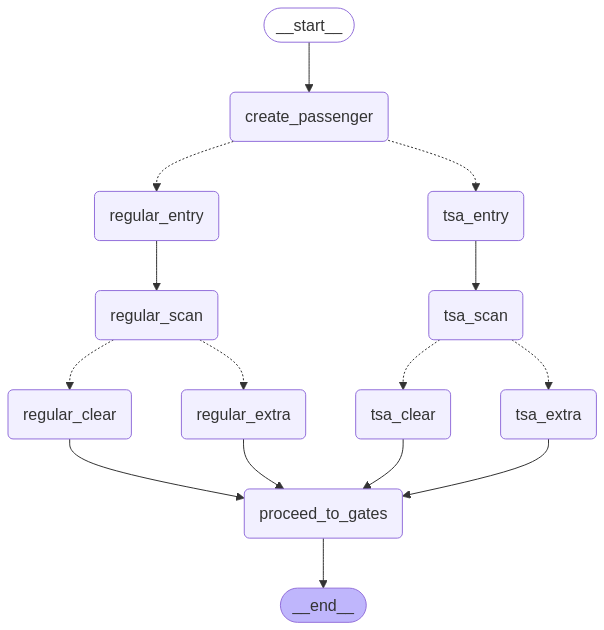


🚀 Processing New Passenger 🚀
🛫 Passenger enters airport security.
🎒 Luggage: ['Clothes', 'Toothbrush', 'Laptop', 'Phone Charger', 'Books', 'Travel Guide', 'Camera', 'Snacks', 'Water Bottle', 'Travel Adapter']
🟢 Passenger is TSA PreCheck.
🟢 TSA passenger enters screening.
🛃 AI Screening Decision: ✅ Cleared for Gates. (No, none of the items listed in the luggage are prohibited or dangerous. They are all common travel items.)
✅ Passenger cleared security. Proceeding to gates!
✅ Passenger cleared security. Proceeding to gates!

📈 FINAL STATS: 1 Total, 0 Flagged

🚀 Processing New Passenger 🚀
🛫 Passenger enters airport security.
🎒 Luggage: ['Laptop', 'Toothbrush', 'Clothes', 'Chargers', 'Books', 'Travel-size Toiletries']
🔵 Passenger is Regular Screening.
🔎 Regular passenger enters screening.
🛃 AI Screening Decision: ✅ Cleared for Gates. (No, the passenger should not be flagged. The items in their luggage are common for traveling and do not include any prohibited or suspicious items.)
✅ Pass

In [66]:
from typing_extensions import TypedDict, Annotated
from typing import Literal
import random
import json
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from google.colab import userdata
from langchain.schema import AIMessage, HumanMessage

# 🔑 Secure OpenAI API Key
OPENAI_API_KEY = userdata.get('OpenAI_Key')
llm = ChatOpenAI(model="gpt-4", temperature=0.7, api_key=OPENAI_API_KEY)

# 🎯 Define State Schema
class AirportState(TypedDict):
    passenger_type: str  # "TSA" or "Regular"
    luggage: Annotated[list, "merge"]  # Luggage details (set once)
    screening_notes: Annotated[list, "merge"]  # Screening decisions
    flagged: bool  # True if extra screening is needed

# 🏗️ Initialize Persistent Memory
memory_store = {"total_passengers": 0, "flagged_passengers": 0}

def create_passenger(state: AirportState) -> AirportState:
    """Creates a passenger and assigns luggage."""
    print("🛫 Passenger enters airport security.")

    # Generate luggage inside this function
    if "luggage" not in state or not state["luggage"]:

        # 🔀 Random chance to include dangerous items (10% of the time)
        if random.random() < 0.3:
            prompt = (
                "List 6-10 items in the passenger's luggage, including 1-2 dangerous items "
                "that might require extra screening. Format response as a JSON list."
                "(Example: [\"Laptop\", \"Water Bottle\", \"Pocket Knife\", \"Lighter\"])"
            )
            print("⚠️ Generating luggage with potential dangerous items...")
        else:
            prompt = (
                "List 6-10 common travel items in the passenger's luggage. "
                "Do NOT include dangerous items. Format response as a JSON list."
                "(Example: [\"Backpack\", \"Sunglasses\", \"Travel Pillow\", \"Shoes\"])"
            )

        # 🧠 Get response from LLM
        response = llm([HumanMessage(content=prompt)])

        try:
            items = json.loads(response.content)
            if isinstance(items, list):
                state["luggage"] = items
            else:
                raise ValueError("Invalid format received from LLM.")
        except json.JSONDecodeError:
            state["luggage"] = ["Unknown Item"]  # Fallback

    print(f"🎒 Luggage: {state['luggage']}")
    return state


def assign_lane(state: AirportState) -> Literal["tsa_entry", "regular_entry"]:
    """Assigns passenger to TSA or Regular screening."""
    if random.random() < 0.3:
        print("🟢 Passenger is TSA PreCheck.")
        state["passenger_type"] = "TSA"
        return "tsa_entry"
    else:
        print("🔵 Passenger is Regular Screening.")
        state["passenger_type"] = "Regular"
        return "regular_entry"

# ✅ TSA-ONLY SCREENING PATH
def tsa_entry(state: AirportState) -> AirportState:
    """TSA passengers enter the TSA checkpoint."""
    print("🟢 TSA passenger enters screening.")
    return state

def tsa_scan(state: AirportState) -> AirportState:
    """AI scans TSA passenger luggage for prohibited items."""
    return run_ai_screening(state, "TSA")

def tsa_decision(state: AirportState) -> Literal["tsa_extra", "tsa_clear"]:
    """Determines if TSA passenger needs extra screening."""
    return "tsa_extra" if state["flagged"] else "tsa_clear"

def tsa_extra(state: AirportState) -> AirportState:
    """TSA passengers flagged for extra screening."""
    print("⚠️ TSA passenger undergoing additional screening.")
    state.setdefault("screening_notes", []).append("TSA passenger sent to extra screening.")
    return state

def tsa_clear(state: AirportState) -> AirportState:
    """TSA passenger cleared to board."""
    return proceed_to_gates(state)

# ✅ REGULAR-ONLY SCREENING PATH
def regular_entry(state: AirportState) -> AirportState:
    """Regular passengers enter the standard security checkpoint."""
    print("🔎 Regular passenger enters screening.")
    return state

def regular_scan(state: AirportState) -> AirportState:
    """AI scans Regular passenger luggage for prohibited items."""
    return run_ai_screening(state, "Regular")

def regular_decision(state: AirportState) -> Literal["regular_extra", "regular_clear"]:
    """Determines if Regular passenger needs extra screening."""
    return "regular_extra" if state["flagged"] else "regular_clear"

def regular_extra(state: AirportState) -> AirportState:
    """Regular passengers flagged for extra screening."""
    print("⚠️ Regular passenger undergoing additional screening.")
    state.setdefault("screening_notes", []).append("Regular passenger sent to extra screening.")
    return state

def regular_clear(state: AirportState) -> AirportState:
    """Regular passenger cleared to board."""
    return proceed_to_gates(state)

# ✅ COMMON FINAL NODE
def proceed_to_gates(state: AirportState) -> AirportState:
    """Passengers cleared from both TSA & Regular screenings go to gates."""
    print("✅ Passenger cleared security. Proceeding to gates!")
    return state

# ✅ AI SCREENING FUNCTION (Shared)
def run_ai_screening(state: AirportState, passenger_type: str) -> AirportState:
    """AI determines if luggage requires additional screening."""
    global memory_store  # ✅ Track memory stats here

    prompt = f"Luggage: {state['luggage']}. Should this {passenger_type} passenger be flagged? Answer 'Yes' or 'No' with a short reason."
    response = llm([HumanMessage(content=prompt)])

    state["flagged"] = "yes" in response.content.lower()
    state.setdefault("screening_notes", []).append(response.content)

    # ✅ Update global memory stats
    memory_store["total_passengers"] += 1
    if state["flagged"]:
        memory_store["flagged_passengers"] += 1

    decision = "⚠️ Extra Screening Required!" if state["flagged"] else "✅ Cleared for Gates."
    print(f"🛃 AI Screening Decision: {decision} ({response.content})")

    return state

# 🏗️ Build Graph
builder = StateGraph(AirportState)

# 🔵 Add Nodes
builder.add_node("create_passenger", create_passenger)
builder.add_node("tsa_entry", tsa_entry)
builder.add_node("regular_entry", regular_entry)
builder.add_node("tsa_scan", tsa_scan)
builder.add_node("regular_scan", regular_scan)
builder.add_node("tsa_extra", tsa_extra)
builder.add_node("regular_extra", regular_extra)
builder.add_node("tsa_clear", tsa_clear)
builder.add_node("regular_clear", regular_clear)
builder.add_node("proceed_to_gates", proceed_to_gates)

# 🔗 Define Flow
builder.add_edge(START, "create_passenger")
builder.add_conditional_edges("create_passenger", assign_lane)

# TSA Path
builder.add_edge("tsa_entry", "tsa_scan")
builder.add_conditional_edges("tsa_scan", tsa_decision)
builder.add_edge("tsa_extra", "proceed_to_gates")
builder.add_edge("tsa_clear", "proceed_to_gates")

# Regular Path
builder.add_edge("regular_entry", "regular_scan")
builder.add_conditional_edges("regular_scan", regular_decision)
builder.add_edge("regular_extra", "proceed_to_gates")
builder.add_edge("regular_clear", "proceed_to_gates")

builder.add_edge("proceed_to_gates", END)

# ✅ Compile and Run
graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

# 🚀 Run for Multiple Passengers
for _ in range(6):  # Process 10 passengers in a single run
    print("\n🚀 Processing New Passenger 🚀")
    graph.invoke({})
    # ✅ Print Final Stats from Memory
    print(f"\n📈 FINAL STATS: {memory_store['total_passengers']} Total, {memory_store['flagged_passengers']} Flagged")


# 🔗 Chain  

A simple graph has been built using **nodes**, **normal edges**, and **conditional edges** to control execution flow.  

## 🎯 Goals  

The next step is to construct a **chain** that integrates key LangChain concepts. This involves:  

- Using **chat messages** as the graph state.  
- Incorporating **chat models** within graph nodes.  
- Binding tools to enhance the chat model's functionality.  
- Executing tool calls within graph nodes for dynamic interactions.  

## 🔗 Reference Table  

| Concept            | Documentation Link |
|--------------------|------------------|
| Chat Messages     | [Chat Messages](https://python.langchain.com/v0.2/docs/concepts/#messages) |
| Chat Models       | [Chat Models](https://python.langchain.com/v0.2/docs/concepts/#chat-models) |
| Binding Tools     | [Binding Tools](https://python.langchain.com/v0.2/docs/concepts/#tools) |
| Executing Tool Calls | [Tool Calling](https://python.langchain.com/v0.2/docs/concepts/#functiontool-calling) |

## 📌 Chain Structure  

<img src="https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab08dd607b08df5e1101_chain1.png" width="600"/>  


In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph

In [ ]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# Step 1: Create a conversation flow using AI and Human messages
# These messages simulate an interaction between a user (Lance) and an AI model
messages = [
    AIMessage(content="So you said you were researching ocean mammals?", name="Model"),
    HumanMessage(content="Yes, that's right.", name="Lance"),
    AIMessage(content="Great, what would you like to learn about?", name="Model"),
    HumanMessage(content="I want to learn about the best place to see Orcas in the US.", name="Lance"),
]

# Step 2: Print the conversation in a structured format
for m in messages:
    m.pretty_print()

# Step 3: Initialize the graph structure
# This graph will control the decision-making process of the AI
builder = StateGraph(State)

# Step 4: Add nodes to the graph
# Each node represents a different processing step
builder.add_node("node_1", node_1)  # The first step of processing
builder.add_node("node_2", node_2)  # A possible path: AI responds with "happy!"
builder.add_node("node_3", node_3)  # Another path: AI responds with "sad!"

# Step 5: Define edges (connections) between nodes
# The graph starts at "node_1"
builder.add_edge(START, "node_1")

# Step 6: Introduce a conditional decision
# The path from "node_1" to either "node_2" or "node_3" is determined randomly
builder.add_conditional_edges("node_1", decide_mood)

# Step 7: Define the ending condition
# Both "node_2" and "node_3" lead to the END node, concluding the process
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Step 8: Compile the graph
# This ensures that all nodes and edges are correctly linked
graph = builder.compile()

# Step 9: Visualize the graph
# Generates a diagram to show how the nodes and edges are connected
display(Image(graph.get_graph().draw_mermaid_png()))


## 🔗 Understanding the Chat-Based Chain  

This code builds a **chat-driven decision graph** using LangGraph. It begins by simulating a conversation between a user ("Lance") and an AI assistant ("Model") using chat messages. These messages serve as the **initial state** of the graph. The graph structure is then defined, starting with `node_1`, which processes the input. A **conditional edge** determines whether the response follows a **"happy"** or **"sad"** path, leading to `node_2` or `node_3` respectively. The decision is made randomly using the `decide_mood` function. Finally, the graph is compiled and visualized, showing the flow of decisions and responses in a structured manner.


## 🛠️ Understanding the Code: Tool-Enhanced ChatGPT with LangGraph  

### 🔗 **Binding a Tool to the LLM**  
This code integrates a **structured tool (`multiply`)** with an LLM using **LangChain and LangGraph**. The `multiply` function is registered as a tool and bound to the **ChatGPT model (`gpt-3.5-turbo`)**. When the user asks a mathematical question like *"What is 2 multiplied by 3?"*, the LLM **extracts the numbers** and generates a structured tool call. This tool call outputs a **payload** (e.g., `{"a":2, "b":3}`), which is then processed by the tool to return `6`.  

### 📩 **Using a Message-Based State**  
The state in this implementation is managed using **message history (`MessagesState`)**, where interactions between the AI and user are stored as a list of messages. The **`add_messages` reducer** ensures that every new message is appended to the conversation state, allowing the LLM to retain context. This is demonstrated by adding a new message to an existing conversation and verifying that the updated state includes all past interactions.  

### 🔄 **Building and Running the LangGraph Workflow**  
A **LangGraph workflow** is created where:  
1. The conversation state is passed to the **tool-enhanced LLM** (`tool_calling_llm` node).  
2. The LLM **decides whether to use a tool** or respond directly based on the input.  
3. The processed response is returned as the updated message state.  
4. The **graph is visualized** using a Mermaid diagram, displaying the flow between nodes.  

Finally, two test cases are executed:  
- **General query:** The LLM responds conversationally.  
- **Tool-based query:** The LLM detects a multiplication request, generates a tool call, and returns the computed result.  

This approach demonstrates **structured decision-making** in LLM workflows, where the model can **choose between answering naturally or calling an external function** based on the user's intent.


In [ ]:
import openai
import json
from typing_extensions import TypedDict, Annotated
from typing import Dict
from langchain_core.messages import AnyMessage, AIMessage, HumanMessage
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.graph.message import add_messages
from IPython.display import Image, display

# 🏗️ Define a Structured Tool
@tool
def multiply(a: int, b: int) -> int:
    """Multiply two numbers and return the result."""
    return a * b

# 🧠 Initialize the ChatGPT Model with Tool Binding
llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)
llm_with_tools = llm.bind_tools([multiply])  # Bind the multiply function as a tool

# 🔍 Test a Tool Call
tool_call = llm_with_tools.invoke([HumanMessage(content="What is 2 multiplied by 3?", name="Lance")])
print("Tool Call Output:", tool_call.tool_calls)  # Expected Output: {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}

# 📩 Define a State to Store Messages
class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]  # Uses add_messages reducer to append messages

# 📌 Test the Reducer: Appending Messages
initial_messages = [
    AIMessage(content="Hello! How can I assist you?", name="Model"),
    HumanMessage(content="I'm looking for information on marine biology.", name="Lance")
]
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

# ✅ Test the `add_messages` reducer
updated_messages = add_messages(initial_messages, new_message)
print("Updated Messages:", updated_messages)

# 🔧 Define a Node for Tool-Calling LLM
def tool_calling_llm(state: MessagesState):
    """Passes the conversation state to the LLM with tool capabilities."""
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# 🏗️ Build the Graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
graph = builder.compile()

# 📊 Visualize the Graph
display(Image(graph.get_graph().draw_mermaid_png()))

# 📝 Example 1: Invoke LLM without tool usage (General Query)
messages = graph.invoke({"messages": HumanMessage(content="Hello!")})
for m in messages['messages']:
    m.pretty_print()

# 📝 Example 2: Invoke LLM with tool usage (Math Calculation)
messages = graph.invoke({"messages": HumanMessage(content="Multiply 2 and 3")})
for m in messages['messages']:
    m.pretty_print()
